# nuImages devkit tutorial

Welcome to the nuImages tutorial.
This demo assumes the database itself is available at `/data/sets/nuimages`, and loads a mini version of the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -c https://nuscenes.org/nuimages# -P /content/drive/My\ Drive/[您的目标文件夹]/

## A Gentle Introduction to nuImages

In this part of the tutorial, let us go through a top-down introduction of our database. Our dataset is structured as a relational database with tables, tokens and foreign keys. The tables are the following:

1. `log` - Log from which the sample was extracted.
2. `sample` - An annotated camera image with an associated timestamp and past and future images and pointclouds.
3. `sample_data` - An image or pointcloud associated with a sample.
4. `ego_pose` - The vehicle ego pose and timestamp associated with a sample_data.
5. `sensor` - General information about a sensor, e.g. `CAM_BACK_LEFT`.
6. `calibrated_sensor` - Calibration information of a sensor in a log.
7. `category` - Taxonomy of object and surface categories (e.g. `vehicle.car`, `flat.driveable_surface`).
8. `attribute` - Property of an object that can change while the category remains the same.
9. `object_ann` - Bounding box and mask annotation of an object (e.g. car, adult).
10. `surface_ann` - Mask annotation of a surface (e.g. `flat.driveable surface` and `vehicle.ego`).

The database schema is visualized below. For more information see the [schema page](https://github.com/nutonomy/nuscenes-devkit/blob/master/docs/schema_nuimages.md).
![](https://www.nuscenes.org/public/images/nuimages-schema.svg)

## Google Colab (optional)

<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuimages_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left">
</a>
<br>
    
If you are running this notebook in Google Colab, you can uncomment the cell below and run it; everything will be set up nicely for you. Otherwise, manually set up everything.

In [ ]:
!mkdir -p /data/sets/nuimages  # Make the directory to store the nuImages dataset in.

!wget https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz  # Download the nuImages mini split.

!tar -xf nuimages-v1.0-mini.tgz -C /data/sets/nuimages  # Uncompress the nuImages mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuImages.

--2024-02-08 21:56:29--  https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 108.156.120.2, 108.156.120.75, 108.156.120.125, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|108.156.120.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117929607 (112M) [application/x-tar]
Saving to: ‘nuimages-v1.0-mini.tgz’

nuimages-v1.0-mini. 100%[===================>] 112.47M   183MB/s    in 0.6s    

2024-02-08 21:56:30 (183 MB/s) - ‘nuimages-v1.0-mini.tgz’ saved [117929607/117929607]



In [ ]:
! ls

nuimages-v1.0-mini.tgz	sample_data


## Initialization
To initialize the dataset class, we run the code below. We can change the dataroot parameter if the dataset is installed in a different folder. We can also omit it to use the default setup. These will be useful further below.

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from nuimages import NuImages

nuim = NuImages(dataroot='/data/sets/nuimages', version='v1.0-mini', verbose=True, lazy=True)

Loading nuImages tables for version v1.0-mini...
Done loading in 0.001 seconds (lazy=True).


In [ ]:

!python3 nuimages/scripts/render_images.py --mode all --cam_name CAM_FRONT --out_dir /data --out_type image


python3: can't open file '/content/nuimages/scripts/render_images.py': [Errno 2] No such file or directory


## Tables

As described above, the NuImages class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [ ]:
nuim.category[0]

Loaded 25 category(s) in 0.000s,


{'token': '63a94dfa99bb47529567cd90d3b58384',
 'name': 'animal',
 'description': 'All animals, e.g. cats, rats, dogs, deer, birds.'}

To see the list of all tables, simply refer to the `table_names` variable:

In [ ]:
nuim.table_names

['attribute',
 'calibrated_sensor',
 'category',
 'ego_pose',
 'log',
 'object_ann',
 'sample',
 'sample_data',
 'sensor',
 'surface_ann']

### Indexing

Since all tables are lists of dictionaries, we can use standard Python operations on them. A very common operation is to retrieve a particular record by its token. Since this operation takes linear time, we precompute an index that helps to access a record in constant time.

Let us select the first image in this dataset version and split:

In [ ]:
sample_idx = 0
sample = nuim.sample[sample_idx]
sample

Loaded 50 sample(s) in 0.000s,


{'token': '09acd654cb514bdeab8e3afedad74fca',
 'timestamp': 1535352274870176,
 'log_token': '4ed5d1230fcb48d39db895f754e724f9',
 'key_camera_token': '0128b121887b4d0d86b8b1a43ac001e9'}

We can also get the sample record from a sample token:

In [ ]:
sample = nuim.get('sample', sample['token'])
sample

{'token': '09acd654cb514bdeab8e3afedad74fca',
 'timestamp': 1535352274870176,
 'log_token': '4ed5d1230fcb48d39db895f754e724f9',
 'key_camera_token': '0128b121887b4d0d86b8b1a43ac001e9'}

What this does is actually to lookup the index. We see that this is the same index as we used in the first place.

In [ ]:
sample_idx_check = nuim.getind('sample', sample['token'])
assert sample_idx == sample_idx_check

From the sample, we can directly access the corresponding keyframe sample data. This will be useful further below.

In [ ]:
key_camera_token = sample['key_camera_token']
print(key_camera_token)

0128b121887b4d0d86b8b1a43ac001e9


### Lazy loading

Initializing the NuImages instance above was very fast, as we did not actually load the tables. Rather, the class implements lazy loading that overwrites the internal `__getattr__()` function to load a table if it is not already stored in memory. The moment we accessed `category`, we could see the table being loaded from disk. To disable such notifications, just set `verbose=False` when initializing the NuImages object. Furthermore lazy loading can be disabled with `lazy=False`.

## Rendering

To render an image we use the `render_image()` function. We can see the boxes and masks for each object category, as well as the surface masks for ego vehicle and driveable surface. We use the following colors:
- vehicles: orange
- bicycles and motorcycles: red
- pedestrians: blue
- cones and barriers: gray
- driveable surface: teal / green

At the top left corner of each box, we see the name of the object category (if `with_category=True`). We can also set `with_attributes=True` to print the attributes of each object (note that we can only set `with_attributes=True` to print the attributes of each object when `with_category=True`). In addition, we can specify if we want to see surfaces and objects, or only surfaces, or only objects, or neither by setting `with_annotations` to `all`, `surfaces`, `objects` and `none` respectively.

Let us make the image bigger for better visibility by setting `render_scale=2`. We can also change the line width of the boxes using `box_line_width`. By setting it to -1, the line width adapts to the `render_scale`. Finally, we can render the image to disk using `out_path`.

In [ ]:
nuim.render_image(key_camera_token, annotation_type='all',
                  with_category=True, with_attributes=True, box_line_width=-1, render_scale=5)

Output hidden; open in https://colab.research.google.com to view.

Let us find out which annotations are in that image.

In [ ]:
object_tokens, surface_tokens = nuim.list_anns(sample['token'])

Printing object annotations:
06eed0ca8b164b84bbb2851de1ed2c13 vehicle.car ['vehicle.moving']
0e8ba57c7b69482c88319f5c1b4deeb0 movable_object.trafficcone []
11ec9a46540443339e2e38afbe31f7b1 human.pedestrian.adult ['pedestrian.standing']
4b27e4a70d464cb2a2f33d5dbcf85094 human.pedestrian.adult ['pedestrian.moving']
4c76bc9ee7da40668f1d4b294209ae3b human.pedestrian.adult ['pedestrian.standing']
4e61ccd6905644adb0556e1f336cee79 movable_object.barrier []
584cb4bd0e7c4a0b8b1169191ca828a1 vehicle.car ['vehicle.moving']
677a87b7df1a4ee7a7a36bab569cccbd human.pedestrian.adult ['pedestrian.moving']
683e330396134c6393fd77187194990c human.pedestrian.adult ['pedestrian.moving']
82e0c68c0f2440bcb041a51a6f116513 human.pedestrian.adult ['pedestrian.moving']
8dc2b24b1a69434a8aade0cb4e308e8e vehicle.car ['vehicle.moving']
924572ff00404ae59d1ee2f6f6c92274 human.pedestrian.adult ['pedestrian.moving']
9b8ea679730b43d7b6631ceeb56e0ccf human.pedestrian.adult ['pedestrian.moving']
a457fc08800444bc83900e3a12b00

We can see the object_ann and surface_ann tokens. Let's again render the image, but only focus on the first object and the first surface annotation. We can use the `object_tokens` and `surface_tokens` arguments as shown below. We see that only one car and the driveable surface are rendered.

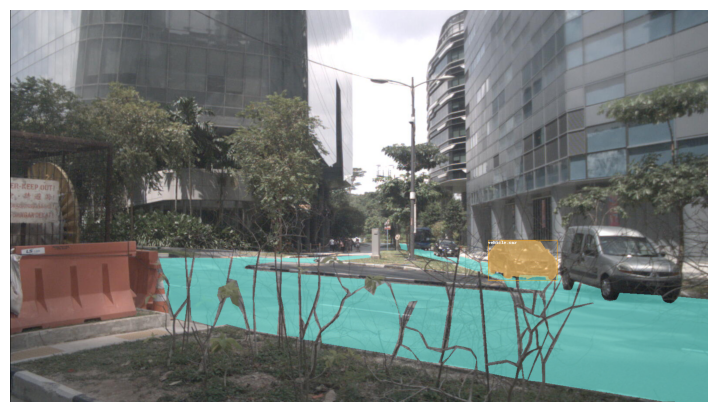

In [ ]:
nuim.render_image(key_camera_token, with_category=True, object_tokens=[object_tokens[0]], surface_tokens=[surface_tokens[0]])

To get the raw data (i.e. the segmentation masks, both semantic and instance) of the above, we can use `get_segmentation()`.

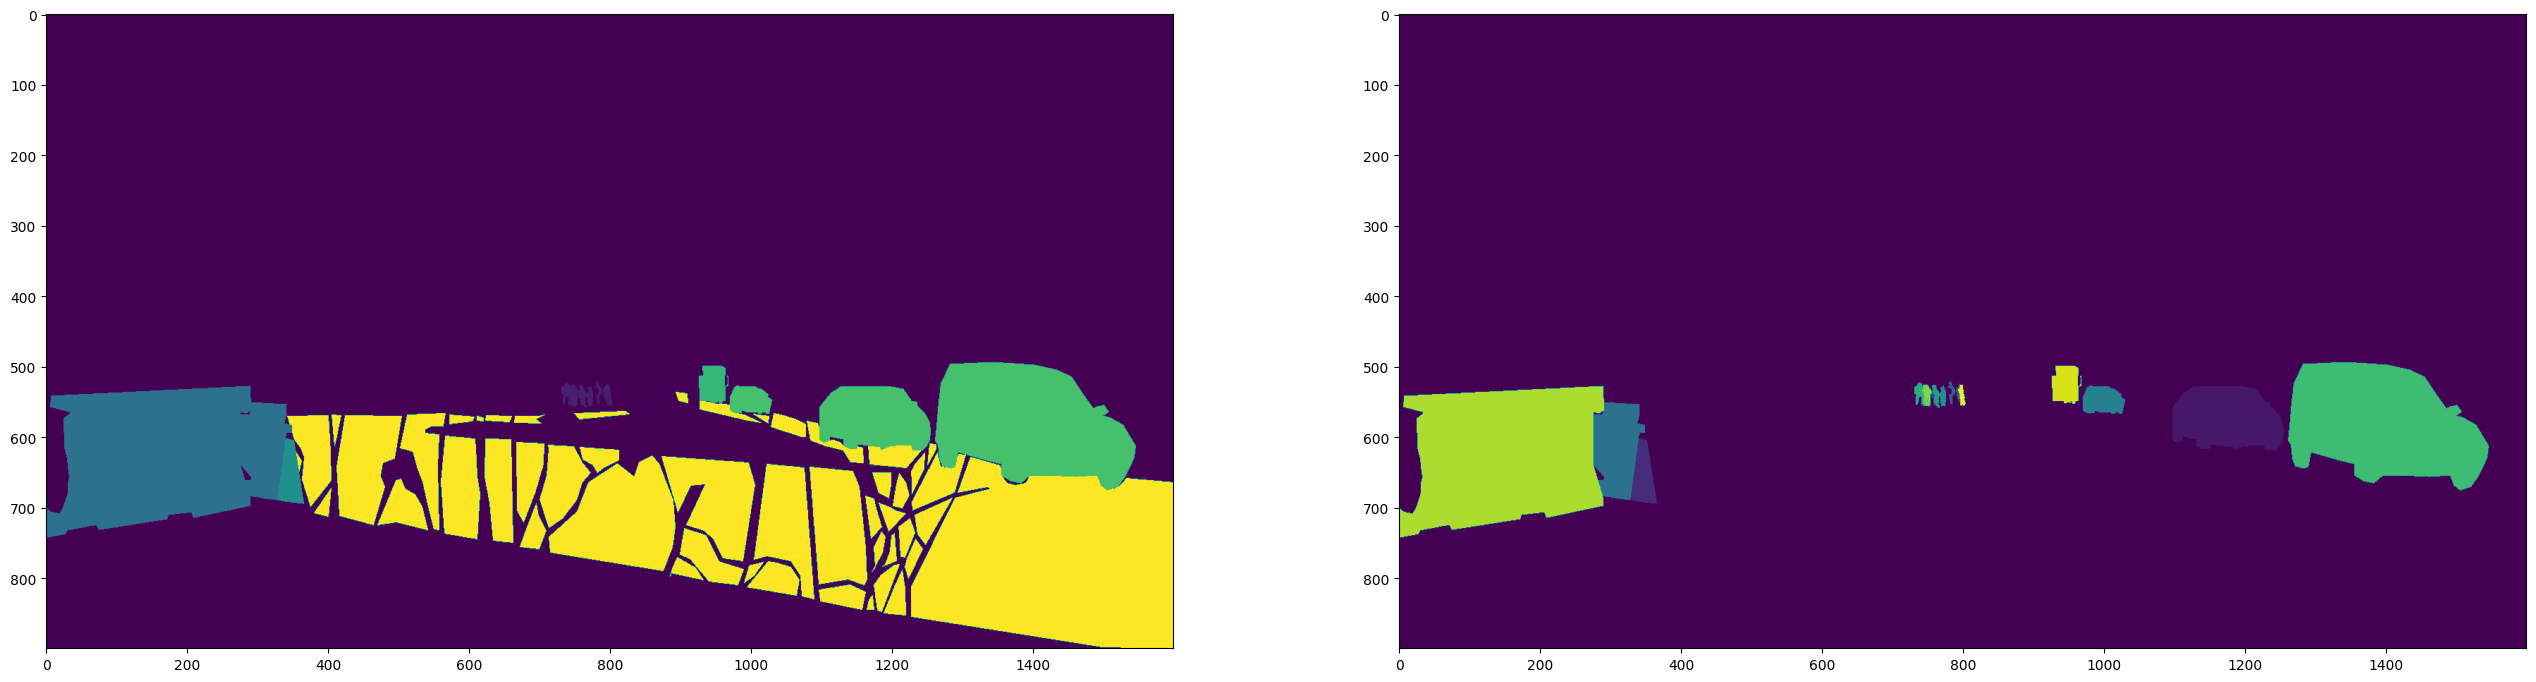

In [ ]:
import matplotlib.pyplot as plt

semantic_mask, instance_mask = nuim.get_segmentation(key_camera_token)

plt.figure(figsize=(32, 9))

plt.subplot(1, 2, 1)
plt.imshow(semantic_mask)
plt.subplot(1, 2, 2)
plt.imshow(instance_mask)

plt.show()

Every annotated image (keyframe) comes with up to 6 past and 6 future images, spaced evenly at 500ms +- 250ms.  However, a small percentage of the samples has less sample_datas, either because they were at the beginning or end of a log, or due to delays or dropped data packages.
`list_sample_content()` shows for each sample all the associated sample_datas.

In [ ]:
nuim.list_sample_content(sample['token'])


Listing sample content...
Rel. time	Sample_data token
     -3.0	0b4fd0e270f2421fbdb7c27caadbc593
     -2.5	f3eadc785a024b3b8af093927d476c2a
     -2.0	aa7dee3a4b824f8a9d894398f18ba1c4
     -1.5	051086dc1e8243fab8731ef5ad7e90a8
     -1.0	26ce6186cc71496fbe07b0b1988c6fb5
     -0.5	24614975bbb34bf385559d958df8008b
      0.0	0128b121887b4d0d86b8b1a43ac001e9
      0.5	5bdc01f564a14f0196817df2a53a41da
      1.0	0a6a50a883f842cba3bf758925b391c6
      1.5	be49e96e81ec4314a6db1f73112ae08f
      2.0	8a18bc3e590b4e0ba904ada6259d1122
      2.5	f1d8370634a948f78084681c25eb9fd6
      3.0	c079819d1520412eb8b99b1c485b1718


Besides the annotated images, we can also render the 6 previous and 6 future images, which are not annotated. Let's select the next image, which is taken around 0.5s after the annotated image. We can either manually copy the token from the list above or use the `next` pointer of the `sample_data`.

In [ ]:
next_camera_token = nuim.get('sample_data', key_camera_token)['next']
next_camera_token

'5bdc01f564a14f0196817df2a53a41da'

Now that we have the next token, let's render it. Note that we cannot render the annotations, as they don't exist.

*Note: If you did not download the non-keyframes (sweeps), this will throw an error! We make sure to catch it here.*

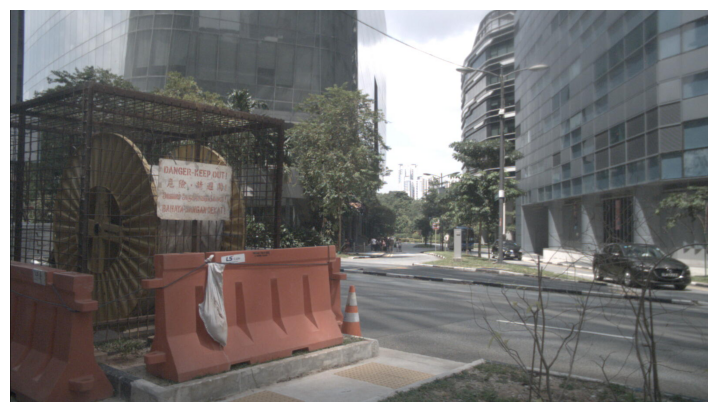

In [ ]:
try:
    nuim.render_image(next_camera_token, annotation_type='none')
except Exception as e:
    print('As expected, we encountered this error:', e)

In this section we have presented a number of rendering functions. For convenience we also provide a script `render_images.py` that runs one or all of these rendering functions on a random subset of the 93k samples in nuImages. To run it, simply execute the following line in your command line. This will save image, depth, pointcloud and trajectory renderings of the front camera to the specified folder.

`>> python nuimages/scripts/render_images.py --mode all --cam_name CAM_FRONT --out_dir ~/Downloads/nuImages --out_type image`

Instead of rendering the annotated keyframe, we can also render a video of the 13 individual images, spaced at 2 Hz.

`>> python nuimages/scripts/render_images.py --mode all --cam_name CAM_FRONT --out_dir ~/Downloads/nuImages --out_type video`

## Poses and CAN bus data

The `ego_pose` provides the translation, rotation, rotation_rate, acceleration and speed measurements closest to each sample_data. We can visualize the trajectories of the ego vehicle throughout the 6s clip of each annotated keyframe. Here the red **x** indicates the start of the trajectory and the green **o** the position at the annotated keyframe.
We can set `rotation_yaw` to have the driving direction at the time of the annotated keyframe point "upwards" in the plot. We can also set `rotation_yaw` to None to use the default orientation (upwards pointing North). To get the raw data of this plot, use `get_ego_pose_data()` or `get_trajectory()`.

In [ ]:
nuim.render_trajectory(sample['token'], rotation_yaw=0, center_key_pose=True)

## Statistics

The `list_*()` methods are useful to get an overview of the dataset dimensions. Note that these statistics are always *for the current split* that we initialized the `NuImages` instance with, rather than the entire dataset.

In [ ]:
nuim.list_logs()

`list_categories()` lists the category frequencies, as well as the category name and description. Each category is either an object or a surface, but not both.

In [ ]:
nuim.list_categories(sort_by='object_freq')

We can also specify a `sample_tokens` parameter for `list_categories()` to get the category statistics for a particular set of samples.

In [ ]:
sample_tokens = [nuim.sample[9]['token']]
nuim.list_categories(sample_tokens=sample_tokens)

`list_attributes()` shows the frequency, name and description of all attributes:

In [ ]:
nuim.list_attributes(sort_by='freq')

`list_cameras()` shows us how many camera entries and samples there are for each channel, such as the front camera.
Each camera uses slightly different intrinsic parameters, which will be provided in a future release.

In [ ]:
nuim.list_cameras()

`list_sample_data_histogram()` shows a histogram of the number of images per annotated keyframe. Note that there are at most 13 images per keyframe. For the mini split shown here, all keyframes have 13 images.

In [ ]:
nuim.list_sample_data_histogram()